In [2]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install seaborn
# !pip install kaggle

## IMPORTAR LIBRERIAS ESTANDAR

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

## DECLARAR FUNCIONES

In [4]:
def get_unpivoted(df, id_vars, var_name, value_name):
    '''
    parameters:
       id_vars: type list, variables ids sobre el cual se toma referencia para el unpivot
       var_name: type str, la nueva variable que se genera a partir de las columnas donde se aplica el unpivot
       value_name: typestr, el valor correspondiente a las variables ids y la nueva variable generada (target)
    return: type dataframe, el nuevo df transformado con el unpivot
    '''
    df = df.melt(id_vars=id_vars, var_name=var_name, value_name=value_name)
    return df

In [5]:
import datetime as dt
def get_dict_semana(since, semana_inicio, semana_fin):
    '''
    parameters:
        since: type str, con el sgte formato 'YYYY-MM-DD'
        semana_inicio: type int, semana inicio de la data
        semana_fin: type int, semana fin de la data
    return: type dict, donde key es la semana_xx y los values son los periodo de inicio y fin de la semana
        
    '''
    periodo_ini = dt.datetime.strptime(since,'%Y-%m-%d')
    list_periodo = []
    for i in range(semana_inicio-1, semana_fin):
        aux = ''
        if i<9:
            aux = '0'+str(i+1)
        else:
            aux = str(i+1)

        periodo_fin = periodo_ini + dt.timedelta(days=6)
        list_periodo.append(['SEMANA_'+aux, periodo_ini, periodo_fin ])
        periodo_ini = periodo_fin + dt.timedelta(days=1)

    dict_semana = {item[0]:{'periodo_ini': item[1], 'periodo_fin':item[2]} for item in list_periodo}
    return dict_semana

In [6]:
def managing_semana(df, dict_semana):
    '''
    Aplicar feature engineering a las variable SEMANA_XX
    '''
    if 'FECHA_INICIO' not in df.columns:
        df['FECHA_INICIO'] = df['SEMANA_XX'].apply(lambda x: dict_semana.get(x)['periodo_ini'])
        df['FECHA_FIN'] = df['SEMANA_XX'].apply(lambda x: dict_semana.get(x)['periodo_fin'])
    return df

In [7]:
def get_dict_categ(df, column):
    '''
    parameters:
      column: type str, se refiere a la variable categorica 
    return: type dict, retorna un key_value de los valores de las variable categorica
    '''
    dict_categ = {}
    for n,i in enumerate(df[column].unique()):
        dict_categ[i] = str(n+1) ### modificar colum
    return dict_categ

In [8]:
def map_valores_categ(df):
    df['Z_MARCA'] = df['Z_MARCA'].map(dict_marca)
    df['Z_MODELO'] = df['Z_MODELO'].map(dict_modelo)
    df['Z_DEPARTAMENTO'] = df['Z_DEPARTAMENTO'].map(dict_departamento)
    df['Z_PUNTO_VENTA'] = df['Z_PUNTO_VENTA'].map(dict_ptoventa)
    df['Z_GAMA'] = df['Z_GAMA'].map(dict_gama)
    return df

In [9]:
def get_feature_selection(fi):
    ##method: encontar las variables con una importancia acumulativa al 99% y las variables con zero importancia
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

In [10]:
def show_values_on_bars(axs, h_v="v", space=0.4, precision=1):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                val = p.get_height()
                if not str(p.get_height())=='nan':
                    value = val
                    if isinstance(value, float):
                        value = round(value, precision)
                    ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## LOAD DATA Y TRANSFORMACION

In [11]:
# /kaggle/input/datathon-entel-2022-reto2
ruta = '../data/'
train_raw = pd.read_csv(ruta+'train.csv')
test_raw =  pd.read_csv(ruta+'test.csv')

In [12]:
### unpivot
id_vars = ['Z_MARCA','Z_MODELO','Z_GAMA','Z_DEPARTAMENTO','Z_PUNTO_VENTA']
var_name = 'SEMANA_XX'
value_name = 'TARGET'

train_transform = get_unpivoted(train_raw, id_vars, var_name, value_name)
test_transform = get_unpivoted(test_raw, id_vars, var_name, value_name)
test_transform['TARGET'] = -1

In [13]:
### featuring engineering semana
dict_semana_train = get_dict_semana(since = '2021-05-17', semana_inicio = 1, semana_fin = 50)
dict_semana_test = get_dict_semana(since = '2022-05-02', semana_inicio = 51, semana_fin = 60)
train_transform = managing_semana(train_transform, dict_semana_train)
test_transform = managing_semana(test_transform, dict_semana_test)
train_transform.shape, test_transform.shape

((2358650, 9), (471730, 9))

In [14]:
## concat
demanda = pd.concat([train_transform, test_transform], axis=0)
demanda['TARGET'] = demanda['TARGET'].astype('int32')
demanda['ID'] = (demanda['Z_MODELO']+'|'+demanda['Z_PUNTO_VENTA']+'|'+ demanda['Z_GAMA']+'|'+demanda['SEMANA_XX'])
demanda.set_index('ID', inplace=True)
demanda.sort_values(['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA','SEMANA_XX'], inplace=True)
demanda

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN
ID,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_01,0,2021-05-17,2021-05-23
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_02,0,2021-05-24,2021-05-30
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_03,0,2021-05-31,2021-06-06
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_04,0,2021-06-07,2021-06-13
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_05,0,2021-06-14,2021-06-20
...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_56,f4920dac3075feca0bd92a92f6691f50e9f815e5e398f8...,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,ee5949f8b5ff823b330c243762295ce7ede1a751f35b94...,ac45b56f385a5564f090e7afd47d721d3a491796bd3a12...,SEMANA_56,-1,2022-06-06,2022-06-12
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_57,f4920dac3075feca0bd92a92f6691f50e9f815e5e398f8...,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,ee5949f8b5ff823b330c243762295ce7ede1a751f35b94...,ac45b56f385a5564f090e7afd47d721d3a491796bd3a12...,SEMANA_57,-1,2022-06-13,2022-06-19
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_58,f4920dac3075feca0bd92a92f6691f50e9f815e5e398f8...,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,ee5949f8b5ff823b330c243762295ce7ede1a751f35b94...,ac45b56f385a5564f090e7af

In [15]:
### label_encoding variables categoricas
dict_marca = get_dict_categ(demanda, 'Z_MARCA')
dict_modelo = get_dict_categ(demanda, 'Z_MODELO')
dict_departamento = get_dict_categ(demanda, 'Z_DEPARTAMENTO')
dict_ptoventa = get_dict_categ(demanda, 'Z_PUNTO_VENTA')
dict_gama = get_dict_categ(demanda, 'Z_GAMA')
demanda = map_valores_categ(demanda)
demanda[['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA','SEMANA_XX','FECHA_INICIO','FECHA_FIN','TARGET']]

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,FECHA_INICIO,FECHA_FIN,TARGET
ID,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,2021-05-17,2021-05-23,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,2021-05-24,2021-05-30,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,2021-05-31,2021-06-06,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,2021-06-07,2021-06-13,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,2021-06-14,2021-06-20,0
...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_56,17,318,1,24,414,SEMANA_56,2022-06-06,2022-06-12,-1
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_57,17,318,1,24,414,SEMANA_57,2022-06-13,2022-06-19,-1
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_58,17,318,1,24,414,SEMANA_58,2022-06-20,2022-06-26,-1


## EDA

In [15]:
demanda_train = demanda[demanda['TARGET']>=0].copy()
demanda_test = demanda[demanda['TARGET']<0].copy()

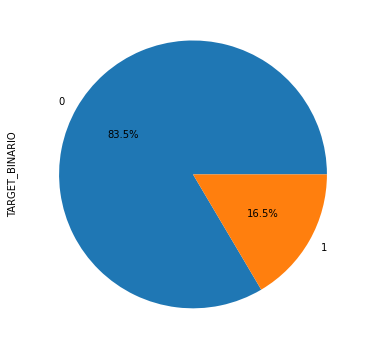

In [16]:
demanda_train['TARGET_BINARIO'] = demanda_train['TARGET'].apply(lambda x:  0 if x<1 else 1)
demanda_train['TARGET_BINARIO'].value_counts().plot.pie(autopct='%.1f%%', figsize=(6,8));

In [17]:
demanda_train[['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA',
               'SEMANA_XX','FECHA_INICIO','FECHA_FIN','TARGET']].tail(50)

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,FECHA_INICIO,FECHA_FIN,TARGET
ID,,,,,,,,,
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,17,318,1,24,414,SEMANA_01,2021-05-17,2021-05-23,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,17,318,1,24,414,SEMANA_02,2021-05-24,2021-05-30,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,17,318,1,24,414,SEMANA_03,2021-05-31,2021-06-06,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,17,318,1,24,414,SEMANA_04,2021-06-07,2021-06-13,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,17,318,1,24,414,SEMANA_05,2021-06-14,2021-06-20,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_06,17,318,1,24,414,SEMANA_06,2021-06-21,2021-06-27,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_07,17,318,1,24,414,SEMANA_07,2021-06-28,2021-07-04,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_08,17,318,1,24,414,SEMANA_08,2021-07-05,2021-07-11,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_09,17,318,1,24,414,SEMANA_09,2021-07-12,2021-07-18,0


### Departamento

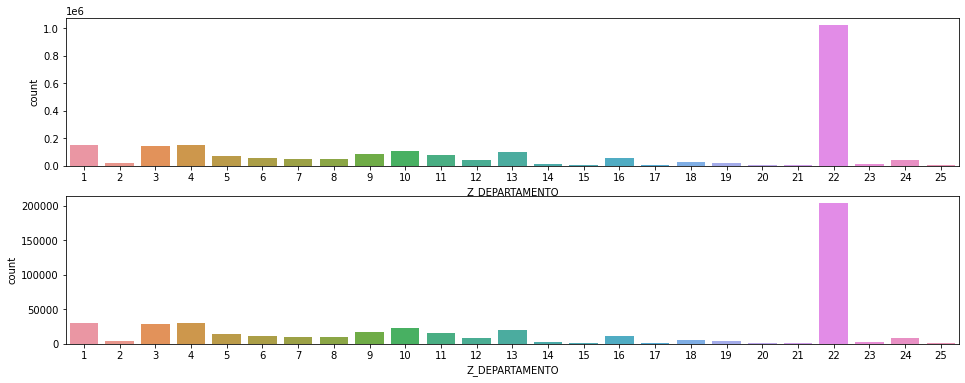

In [18]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(data=demanda_train, x='Z_DEPARTAMENTO', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_DEPARTAMENTO', ax=axes[1]);

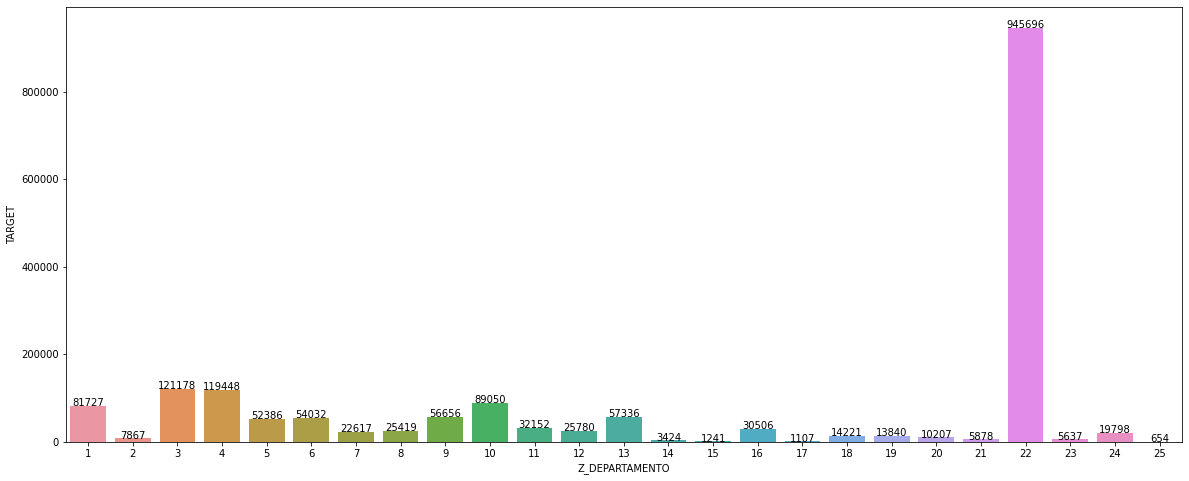

In [19]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

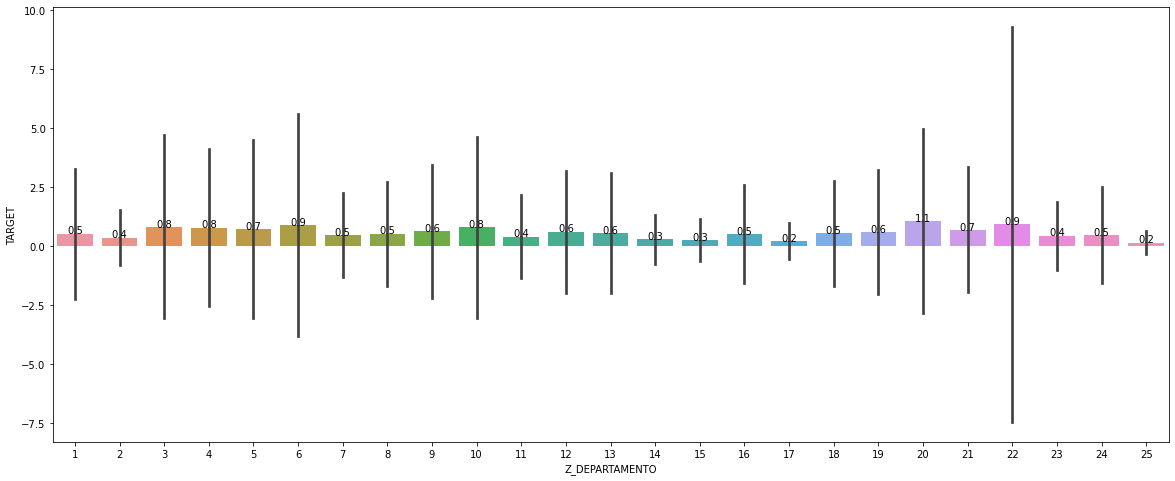

In [20]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

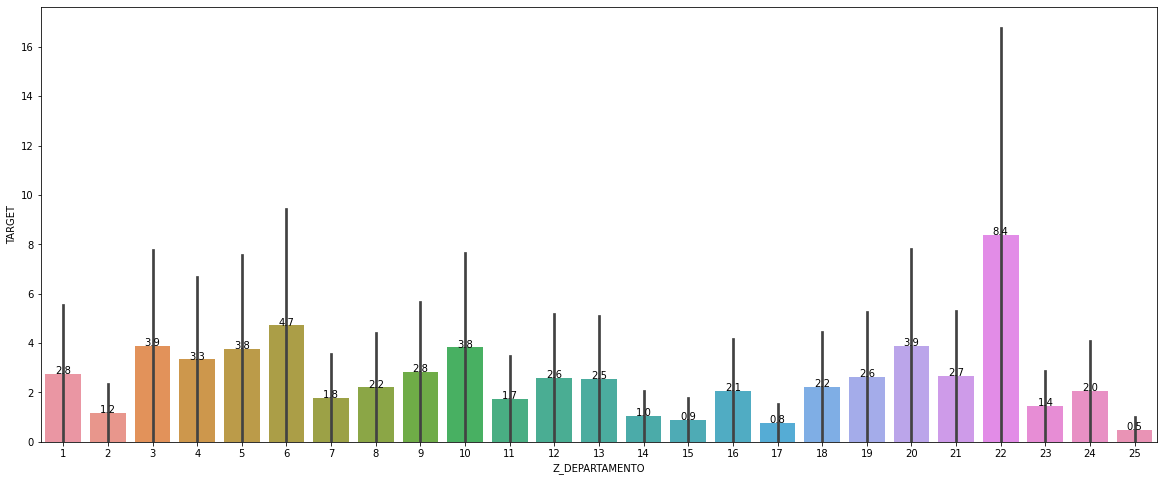

In [21]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

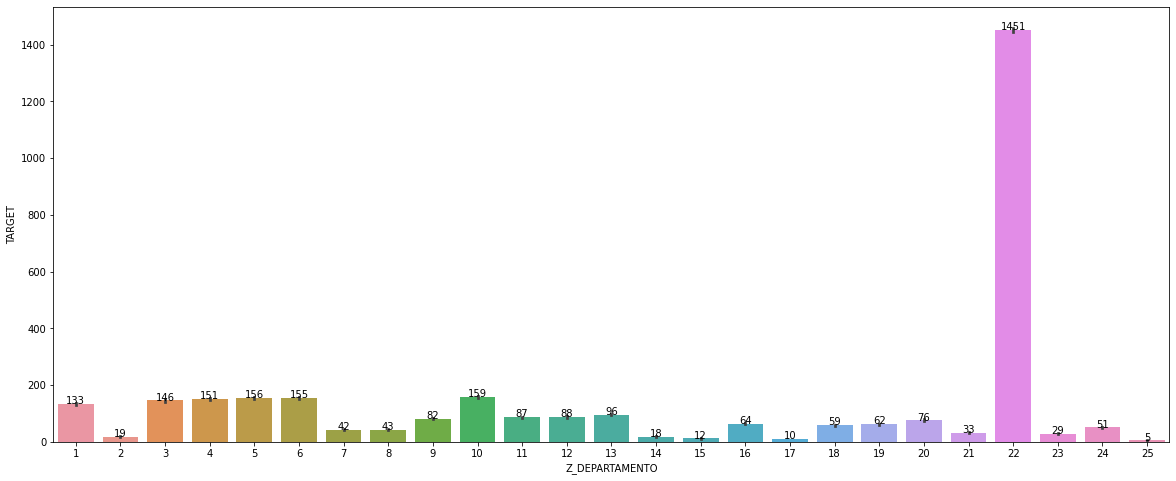

In [22]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Marca

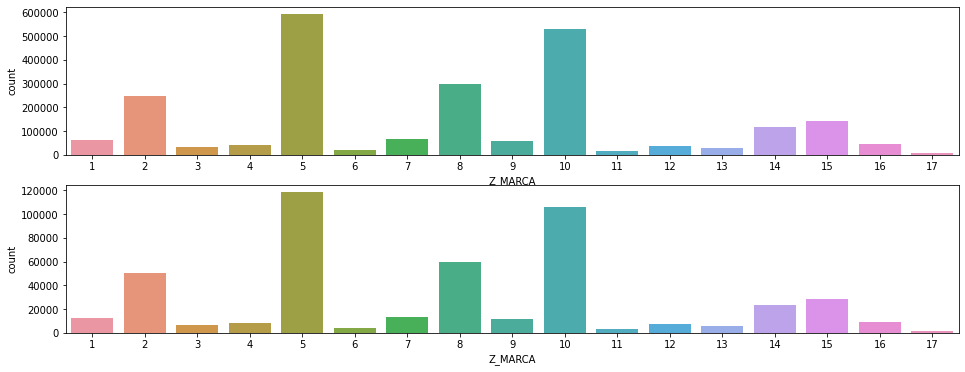

In [23]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(data=demanda_train, x='Z_MARCA', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_MARCA', ax=axes[1]);

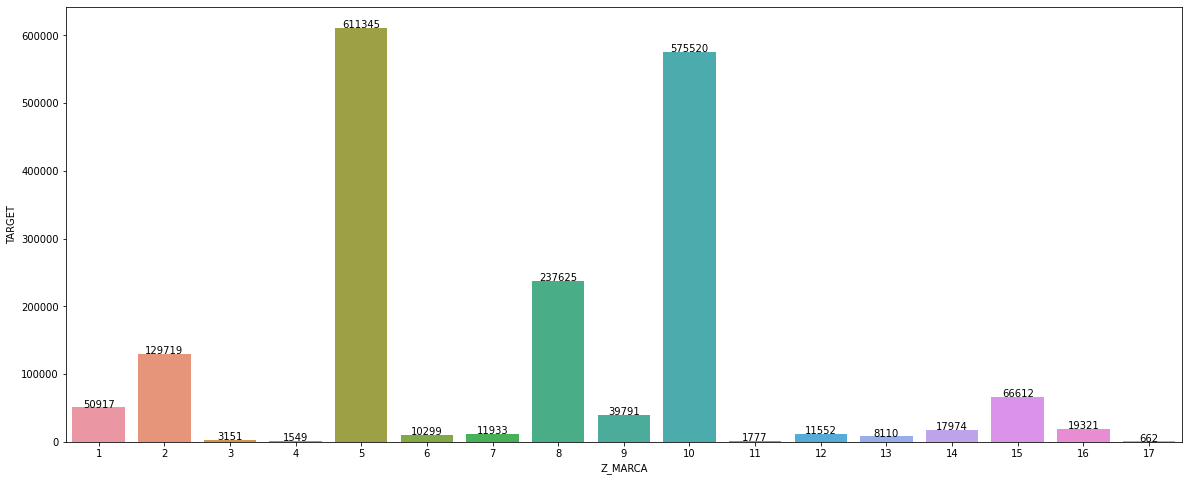

In [24]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

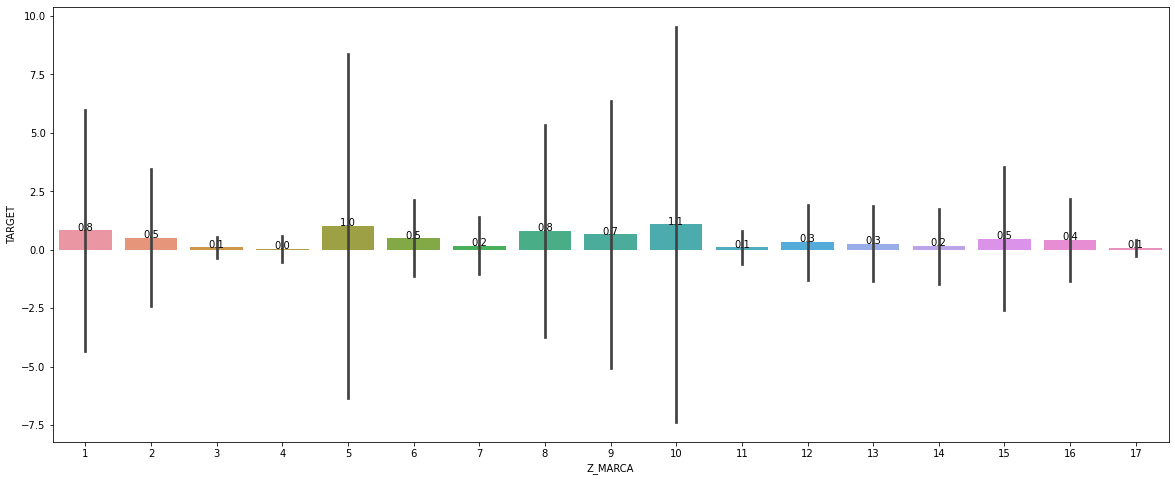

In [25]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

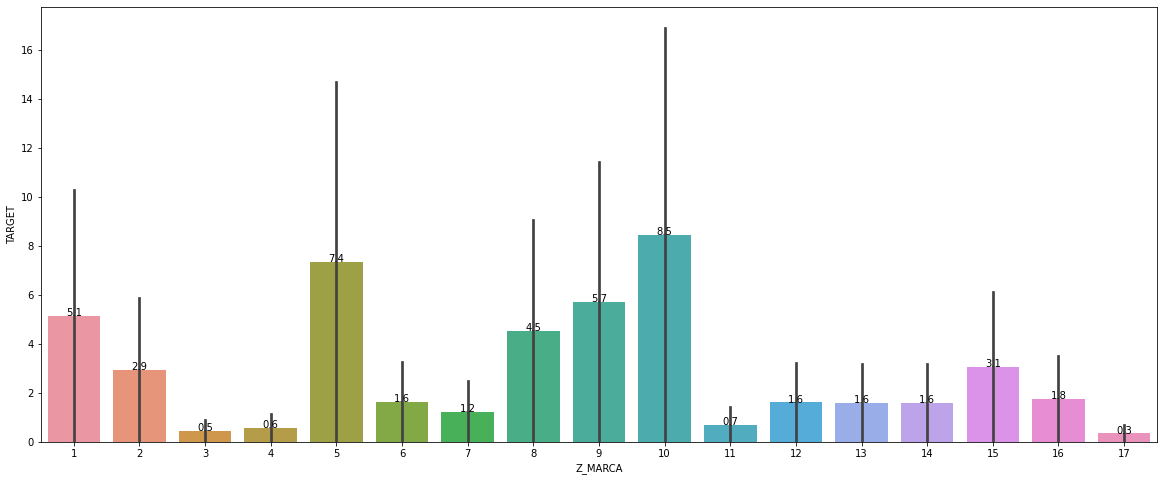

In [26]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

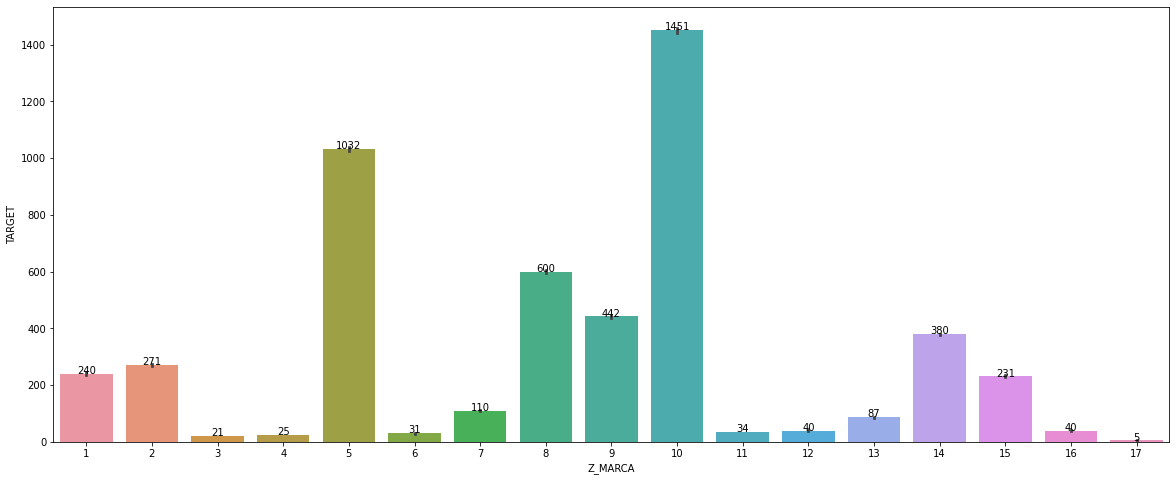

In [27]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Gama

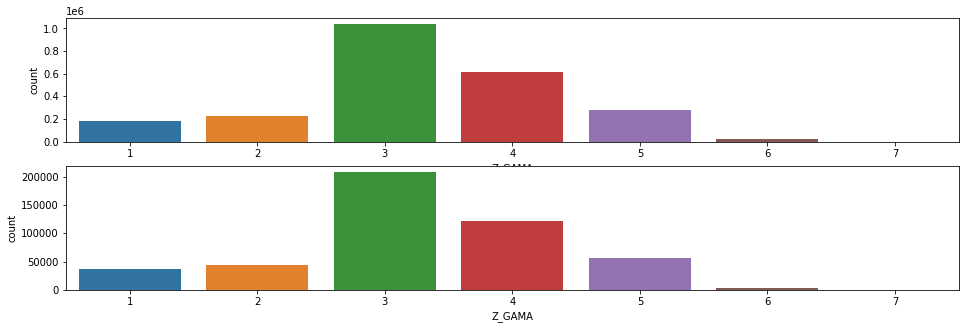

In [28]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 5))
sns.countplot(data=demanda_train, x='Z_GAMA', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_GAMA', ax=axes[1]);

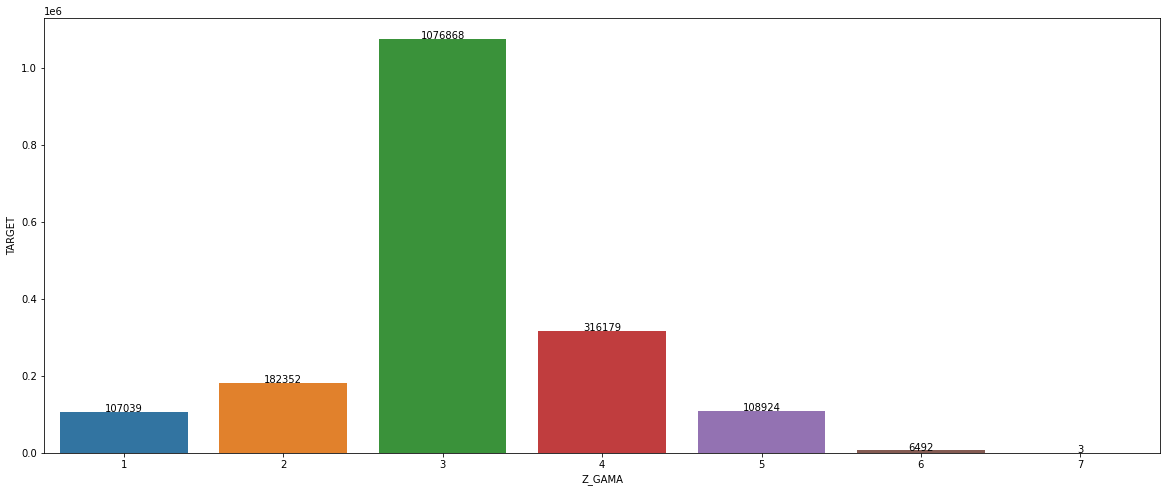

In [29]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

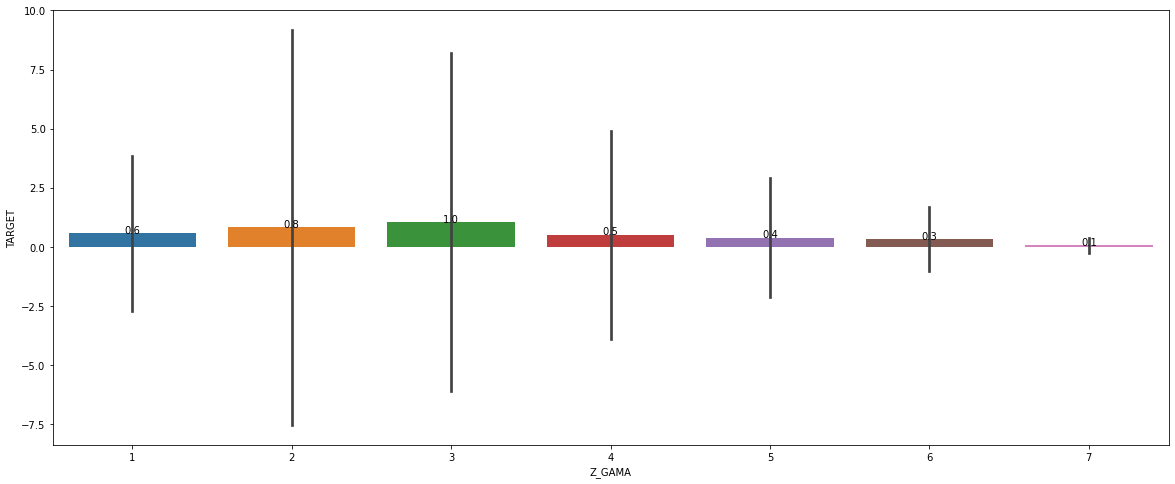

In [30]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

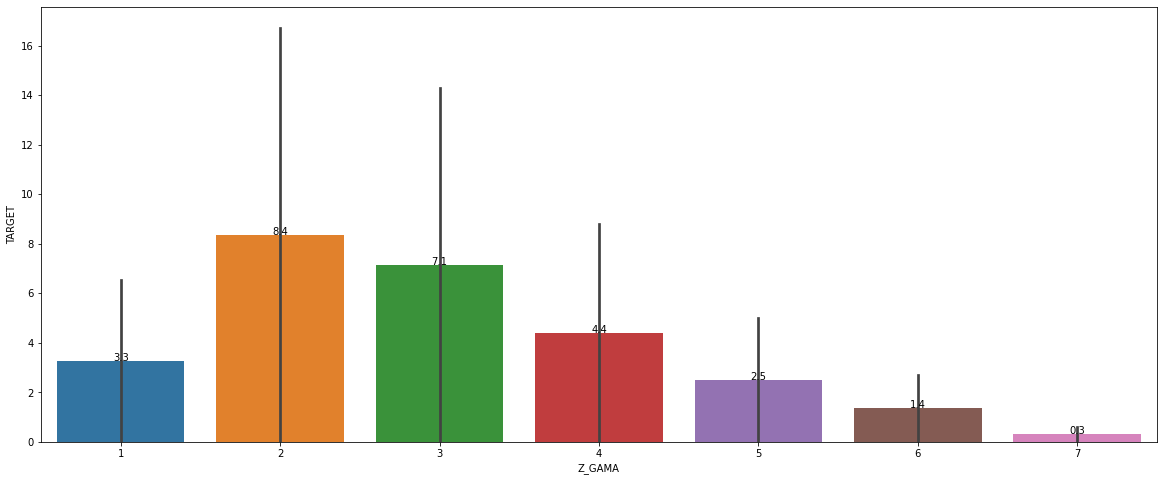

In [31]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

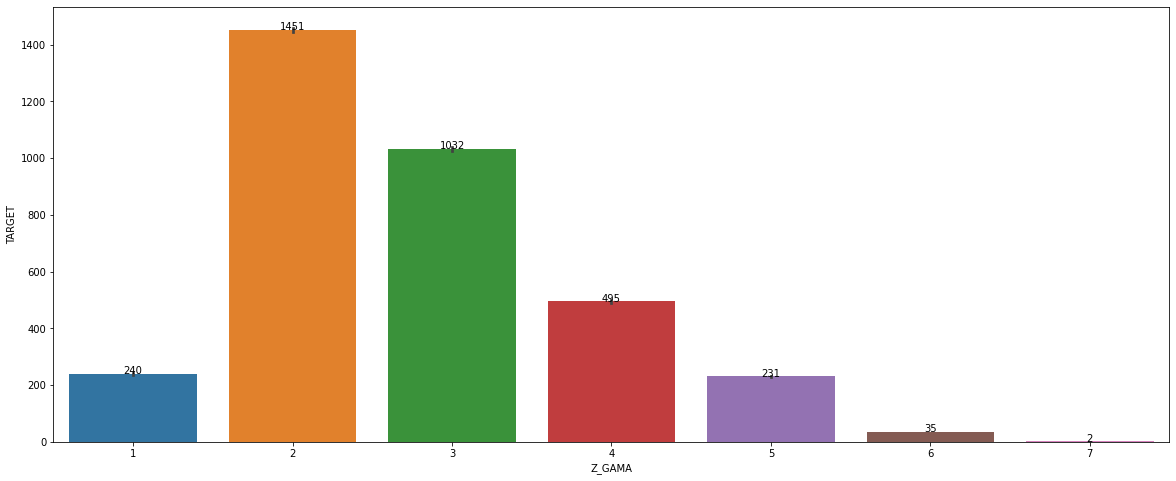

In [32]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Semana_XX

In [33]:
demanda_train['MES_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.strftime('%b'))
demanda_train['ANNIO_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.year)
demanda_train['DIA_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.day)
demanda_train['FECHA_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.strftime('%Y-%m-%d'))
demanda_train

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN,TARGET_BINARIO,MES_INICIO,ANNIO_INICIO,DIA_INICIO
ID,,,,,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,0,2021-05-17,2021-05-23,0,May,2021,17
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,0,2021-05-24,2021-05-30,0,May,2021,24
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,0,2021-05-31,2021-06-06,0,May,2021,31
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,0,2021-06-07,2021-06-13,0,Jun,2021,7
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,0,2021-06-14,2021-06-20,0,Jun,2021,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_46,17,318,1,24,414,SEMANA_46,0,2022-03-28,2022-04-03,0,Mar,2022,28
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_47,17,318,1,24,414,SEMANA_47,0,2022-04-04,2022-04-10,0,Apr,2022,4
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_48,17,318,1,24,414,SEMANA_48,0,2022-04-11,2022-04-17,0,Apr,2022,11


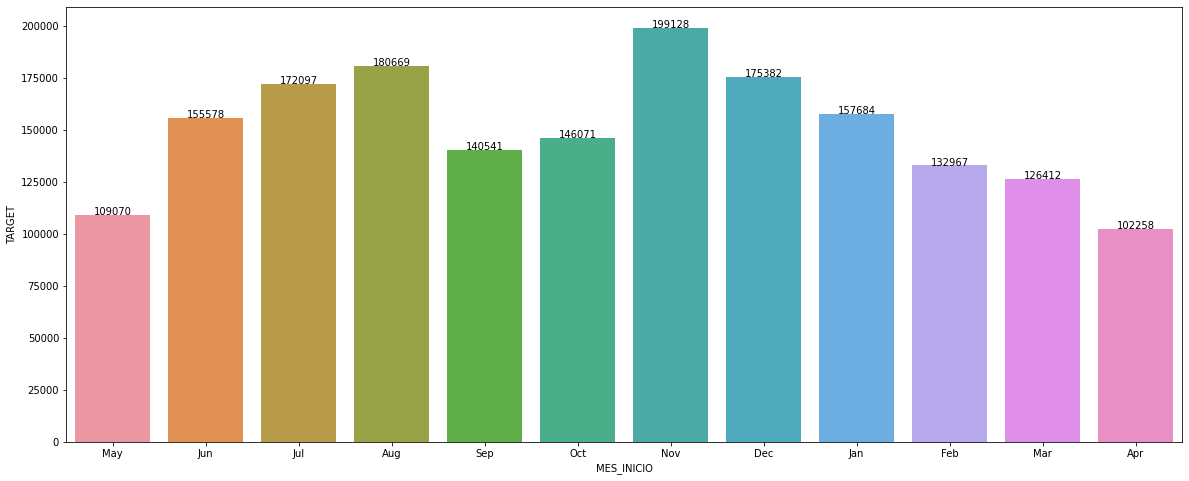

In [34]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='MES_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

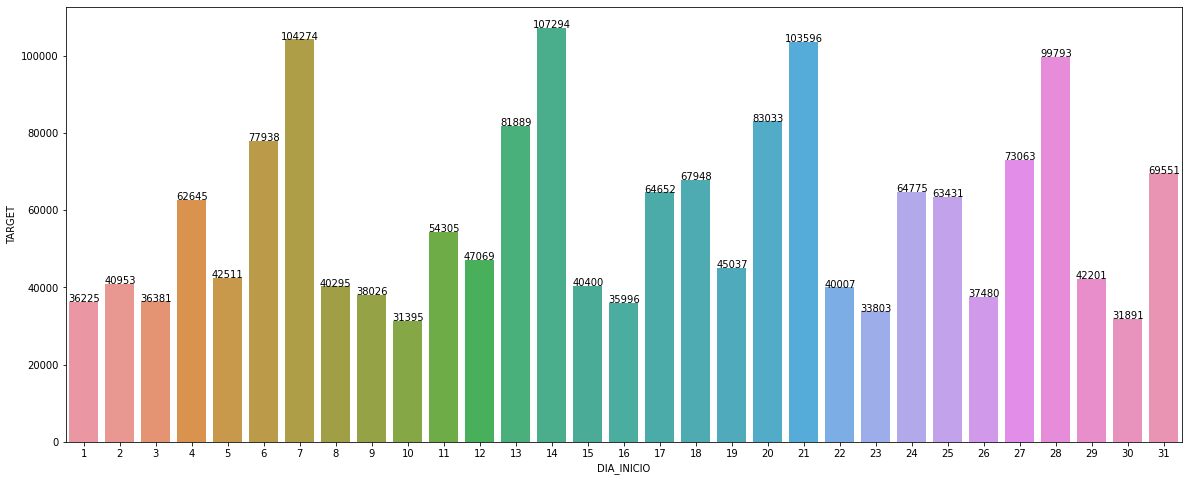

In [35]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='DIA_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

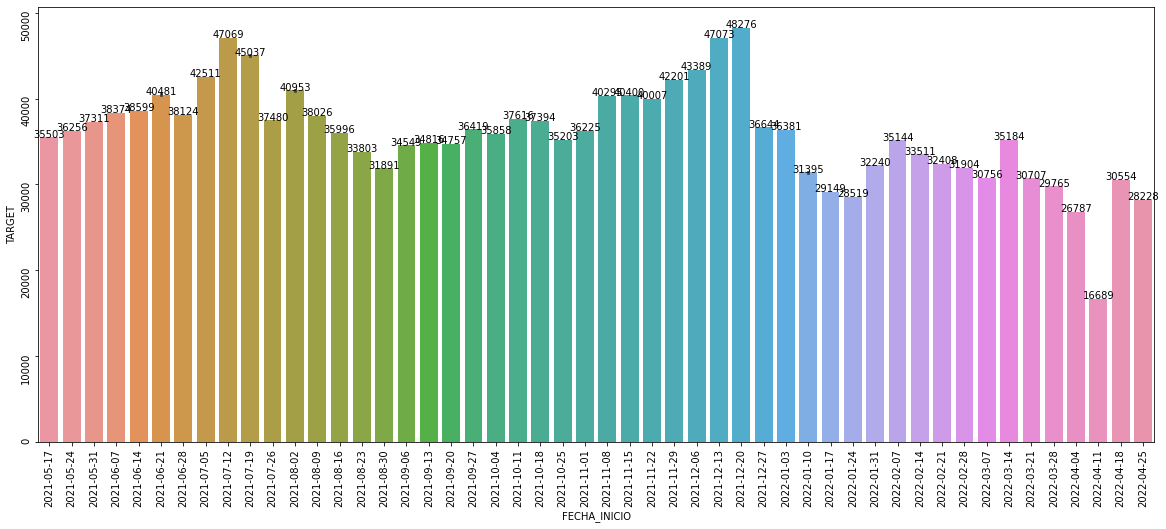

In [36]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='FECHA_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
axs.tick_params(rotation=90)
plt.show()

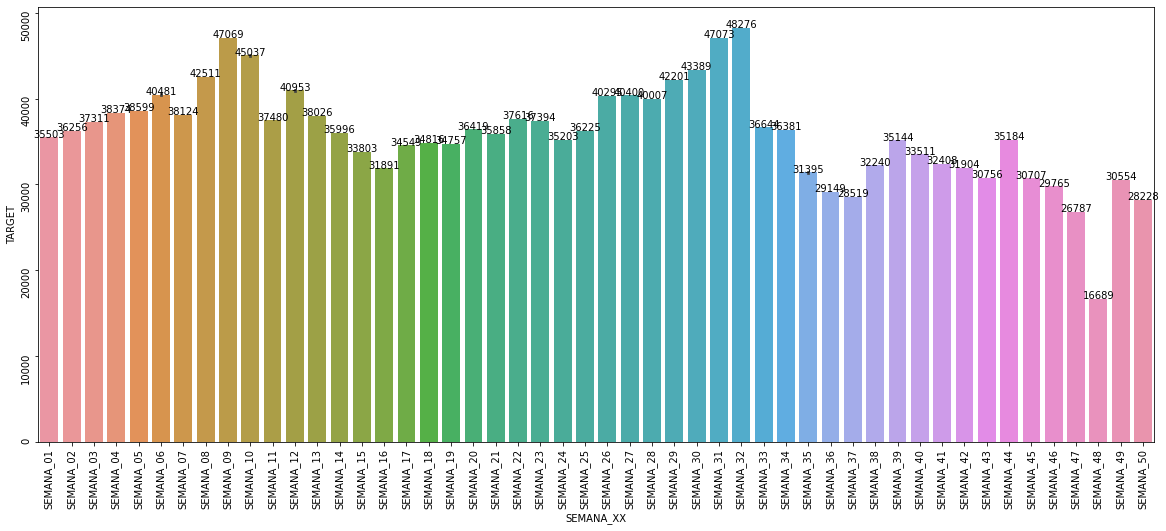

In [37]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
axs.tick_params(rotation=90)
plt.show()

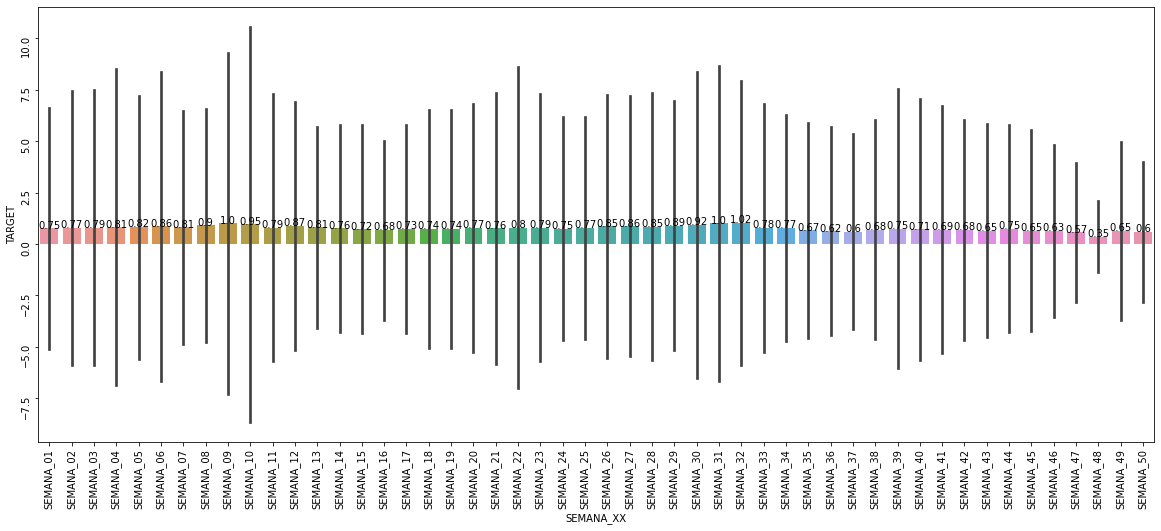

In [38]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

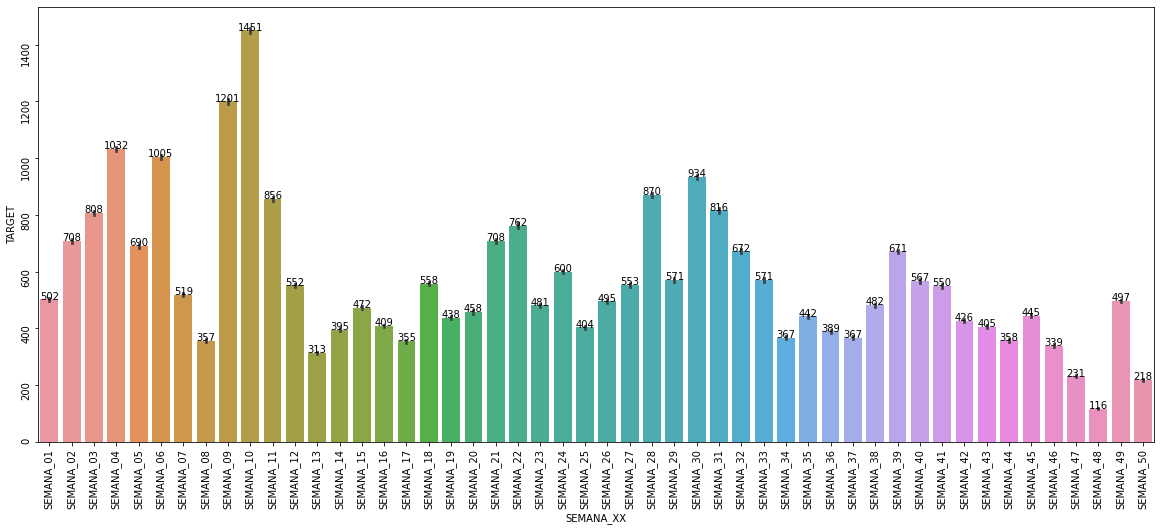

In [39]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

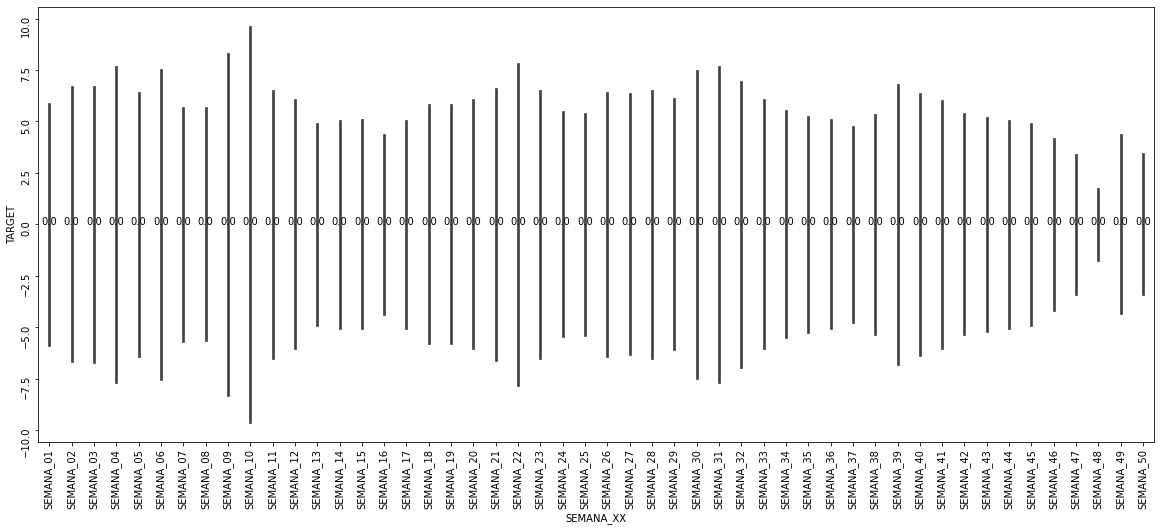

In [40]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.median, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

## FEATURE ENGINEERING

In [16]:
demanda['MES_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.month).astype('int32')
demanda['DIA_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.day).astype('int32')
demanda['ANNIO_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.year).astype('int32')
demanda['MES_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.month).astype('int32')
demanda['DIA_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.day).astype('int32')
demanda['ANNIO_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.year).astype('int32')
demanda['ANNIO_SEMANA_FIN'] = (demanda['FECHA_FIN'].astype(str).str[:4] + demanda['SEMANA_XX'].str[-2:]).astype('int32')
demanda

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN,MES_INICIO,DIA_INICIO,ANNIO_INICIO,MES_FIN,DIA_FIN,ANNIO_FIN,ANNIO_SEMANA_FIN
ID,,,,,,,,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,0,2021-05-17,2021-05-23,5,17,2021,5,23,2021,202101
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,0,2021-05-24,2021-05-30,5,24,2021,5,30,2021,202102
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,0,2021-05-31,2021-06-06,5,31,2021,6,6,2021,202103
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,0,2021-06-07,2021-06-13,6,7,2021,6,13,2021,202104
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,0,2021-06-14,2021-06-20,6,14,2021,6,20,2021,202105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_56,17,318,1,24,414,SEMANA_56,-1,2022-06-06,2022-06-12,6,6,2022,6,12,2022,202256
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_57,17,318,1,24,414,SEMANA_57,-1,2022-06-13,2022-06-19,6,13,2022,6,19,2022,202257
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_58,17,318,1,24,414,SEMANA_58,-1,2022-06-20,2022-06-26,6,20,2022,6,26,2022,202258


In [17]:
demanda_train = demanda[demanda['TARGET']>=0].copy()

In [18]:
### 
mean_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.mean().to_dict()
mean_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.mean().to_dict()
mean_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.mean().to_dict()
mean_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.mean().to_dict()

###
std_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.std().to_dict()
std_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.std().to_dict()
std_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.std().to_dict()
std_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.std().to_dict()

###
max_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.max().to_dict()
max_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.max().to_dict()
max_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.max().to_dict()
max_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.max().to_dict()

###
sum_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.sum().to_dict()
sum_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.sum().to_dict()
sum_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.sum().to_dict()
sum_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.sum().to_dict()

In [19]:
#####
demanda['MODELO_mean_ENC'] = demanda['Z_MODELO'].map(mean_encoding_modelo)
demanda['PTOVENTA_mean_ENC'] = demanda['Z_PUNTO_VENTA'].map(mean_encoding_ptoventa)
demanda['MARCA_mean_ENC'] = demanda['Z_MARCA'].map(mean_encoding_marca)
demanda['GAMA_mean_ENC'] = demanda['Z_GAMA'].map(mean_encoding_gama)

#####
demanda['MODELO_std_ENC'] = demanda['Z_MODELO'].map(std_encoding_modelo)
demanda['PTOVENTA_std_ENC'] = demanda['Z_PUNTO_VENTA'].map(std_encoding_ptoventa)
demanda['MARCA_std_ENC'] = demanda['Z_MARCA'].map(std_encoding_marca)
demanda['GAMA_std_ENC'] = demanda['Z_GAMA'].map(std_encoding_gama)

#####
demanda['MODELO_max_ENC'] = demanda['Z_MODELO'].map(max_encoding_modelo)
demanda['PTOVENTA_max_ENC'] = demanda['Z_PUNTO_VENTA'].map(max_encoding_ptoventa)
demanda['MARCA_max_ENC'] = demanda['Z_MARCA'].map(max_encoding_marca)
demanda['GAMA_max_ENC'] = demanda['Z_GAMA'].map(max_encoding_gama)

#####
demanda['MODELO_sum_ENC'] = demanda['Z_MODELO'].map(sum_encoding_modelo)
demanda['PTOVENTA_sum_ENC'] = demanda['Z_PUNTO_VENTA'].map(sum_encoding_ptoventa)
demanda['MARCA_sum_ENC'] = demanda['Z_MARCA'].map(sum_encoding_marca)
demanda['GAMA_sum_ENC'] = demanda['Z_GAMA'].map(sum_encoding_gama)

In [20]:
demanda['PORC_MODELO_mean_max_ENC'] = demanda['MODELO_mean_ENC']/demanda['MODELO_max_ENC'] 
demanda['PORC_PTOVENTA_mean_max_ENC'] = demanda['PTOVENTA_mean_ENC']/demanda['PTOVENTA_max_ENC'] 
demanda['PORC_MARCA_mean_max_ENC'] = demanda['MARCA_mean_ENC']/demanda['MARCA_max_ENC']
demanda['PORC_GAMA_mean_max_ENC'] = demanda['GAMA_mean_ENC']/demanda['GAMA_max_ENC'] 

In [21]:
### Drop Columns
demanda2 = demanda.copy()
drop_columns =['Z_MARCA','Z_GAMA','Z_MODELO','Z_PUNTO_VENTA','Z_DEPARTAMENTO',
              'FECHA_INICIO','FECHA_FIN']
demanda2.drop(drop_columns, axis=1, inplace=True)
demanda2.columns

Index(['SEMANA_XX', 'TARGET', 'MES_INICIO', 'DIA_INICIO', 'ANNIO_INICIO',
       'MES_FIN', 'DIA_FIN', 'ANNIO_FIN', 'ANNIO_SEMANA_FIN',
       'MODELO_mean_ENC', 'PTOVENTA_mean_ENC', 'MARCA_mean_ENC',
       'GAMA_mean_ENC', 'MODELO_std_ENC', 'PTOVENTA_std_ENC', 'MARCA_std_ENC',
       'GAMA_std_ENC', 'MODELO_max_ENC', 'PTOVENTA_max_ENC', 'MARCA_max_ENC',
       'GAMA_max_ENC', 'MODELO_sum_ENC', 'PTOVENTA_sum_ENC', 'MARCA_sum_ENC',
       'GAMA_sum_ENC', 'PORC_MODELO_mean_max_ENC',
       'PORC_PTOVENTA_mean_max_ENC', 'PORC_MARCA_mean_max_ENC',
       'PORC_GAMA_mean_max_ENC'],
      dtype='object')

In [22]:
demanda2.isna().sum()

SEMANA_XX                         0
TARGET                            0
MES_INICIO                        0
DIA_INICIO                        0
ANNIO_INICIO                      0
MES_FIN                           0
DIA_FIN                           0
ANNIO_FIN                         0
ANNIO_SEMANA_FIN                  0
MODELO_mean_ENC                   0
PTOVENTA_mean_ENC                 0
MARCA_mean_ENC                    0
GAMA_mean_ENC                     0
MODELO_std_ENC                    0
PTOVENTA_std_ENC                  0
MARCA_std_ENC                     0
GAMA_std_ENC                      0
MODELO_max_ENC                    0
PTOVENTA_max_ENC                  0
MARCA_max_ENC                     0
GAMA_max_ENC                      0
MODELO_sum_ENC                    0
PTOVENTA_sum_ENC                  0
MARCA_sum_ENC                     0
GAMA_sum_ENC                      0
PORC_MODELO_mean_max_ENC      95460
PORC_PTOVENTA_mean_max_ENC     5040
PORC_MARCA_mean_max_ENC     

## ENTRENAMIENTO 

In [24]:
demanda2['SEMANA_XX'] = demanda2['SEMANA_XX'].astype(str).str[-2:].astype('int32')

In [25]:
y_train = demanda2[demanda2['TARGET']>=0][['TARGET']].copy()
train = demanda2[demanda2['TARGET']>=0].copy()
test = demanda2[demanda2['TARGET']<0].copy()
train.shape, test.shape, y_train.shape

((2358650, 29), (471730, 29), (2358650, 1))

In [26]:
folds = []
folds.append(list(train[(train['SEMANA_XX']>=1) & (train['SEMANA_XX']<=10)].index))
folds.append(list(train[(train['SEMANA_XX']>=11) & (train['SEMANA_XX']<=20)].index))
folds.append(list(train[(train['SEMANA_XX']>=21) & (train['SEMANA_XX']<=30)].index))
folds.append(list(train[(train['SEMANA_XX']>=31) & (train['SEMANA_XX']<=40)].index))
folds.append(list(train[(train['SEMANA_XX']>=41) & (train['SEMANA_XX']<=50)].index))
len(folds), len(folds[0])

(5, 471730)

In [27]:
np.save('../data/folds.npy', folds)

In [28]:
train.drop(['SEMANA_XX', 'TARGET'], axis=1, inplace=True)
test.drop(['SEMANA_XX', 'TARGET'], axis=1, inplace=True)
train.shape, test.shape

((2358650, 27), (471730, 27))

In [29]:
demanda2.to_pickle('../data/preprocessed/demanda2.pkl')
train.to_pickle('../data/preprocessed/train.pkl')
test.to_pickle('../data/preprocessed/test.pkl')
y_train.to_pickle('../data/preprocessed/y_train.pkl')

## CATBOOST

In [28]:
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterGrid

params = ParameterGrid({"max_depth":[12], "learning_rate":[0.2]})

for param in params:
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        learner = CatBoostRegressor(**param, n_estimators=1000, eval_metric = 'RMSE', random_state=42)
        # learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, )

        learner.fit(Xt, yt,  early_stopping_rounds=10, 
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
    print(param)
    print('SCORE RMSE: ', score)

********** 0 **********
0:	learn: 5.0727621	test: 5.0727621	test1: 6.6374419	best: 6.6374419 (0)	total: 656ms	remaining: 10m 55s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 4.668361068
bestIteration = 71

Shrink model to first 72 iterations.
********** 1 **********
0:	learn: 5.5085292	test: 5.5085292	test1: 4.8660907	best: 4.8660907 (0)	total: 550ms	remaining: 9m 9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.456018243
bestIteration = 8

Shrink model to first 9 iterations.
********** 2 **********
0:	learn: 5.2604757	test: 5.2604757	test1: 6.1016470	best: 6.1016470 (0)	total: 476ms	remaining: 7m 55s
100:	learn: 1.8096550	test: 1.8096550	test1: 3.8865015	best: 3.8813523 (96)	total: 1m 1s	remaining: 9m 4s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.865667013
bestIteration = 130

Shrink model to first 131 iterations.
********** 3 **********
0:	learn: 5.3780269	test: 5.3780269	test1: 5.6250243	best: 5.6250243 (0)	total: 6

In [29]:
train_probs.name='probs_cb'
test_probs.name='probs_cb'
train_probs.to_pickle('../data/preprocessed/catboost/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/catboost/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/catboost/fi.pkl')

#### Visualizacion de resultados

In [30]:
fi.sort_values(ascending=False)

PTOVENTA_sum_ENC              0.171364
ANNIO_SEMANA_FIN              0.133550
MODELO_sum_ENC                0.105736
PTOVENTA_max_ENC              0.076840
MODELO_mean_ENC               0.060734
PORC_MODELO_mean_max_ENC      0.059305
MODELO_std_ENC                0.058475
PORC_PTOVENTA_mean_max_ENC    0.051609
MODELO_max_ENC                0.042270
PTOVENTA_std_ENC              0.041606
MES_INICIO                    0.036170
MES_FIN                       0.028465
GAMA_sum_ENC                  0.026228
MARCA_mean_ENC                0.021824
PTOVENTA_mean_ENC             0.014902
GAMA_mean_ENC                 0.014164
PORC_MARCA_mean_max_ENC       0.010726
MARCA_sum_ENC                 0.010482
MARCA_std_ENC                 0.008420
MARCA_max_ENC                 0.007562
DIA_FIN                       0.005697
DIA_INICIO                    0.004269
ANNIO_INICIO                  0.004192
ANNIO_FIN                     0.002980
GAMA_std_ENC                  0.001193
PORC_GAMA_mean_max_ENC   

In [31]:
test_probs.sort_values().unique()

array([0.00000000e+00, 1.18204016e-05, 1.38213582e-05, ...,
       2.22795001e+02, 2.26446737e+02, 2.42720684e+02])

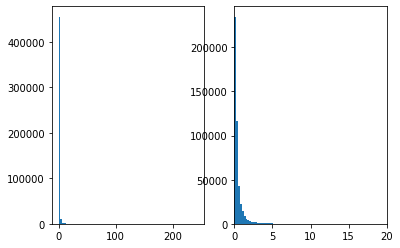

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

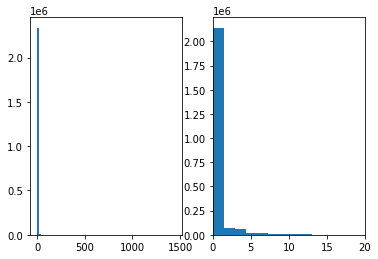

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [34]:
test_probs.describe()

count    471730.000000
mean          0.612842
std           2.318308
min           0.000000
25%           0.154539
50%           0.243925
75%           0.494245
max         242.720684
Name: probs_cb, dtype: float64

In [35]:
test_probs_cb = test_probs.copy()

## LIGHT GBM

In [59]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import ParameterGrid

params = ParameterGrid({ 'max_depth':[15], 'learning_rate':[0.2], 'num_leaves':[100], 'min_split_gain':[0.1] })

for param in params:
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        learner = LGBMRegressor(n_estimators=1000,  random_state=42, n_jobs=-1, **param)
        # learner = LGBMRegressor(n_estimators=1000,  random_state=42)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
    print(param)
    print('SCORE RMSE: ', score)

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 2.92788	training's l2: 8.57248	valid_1's rmse: 5.31857	valid_1's l2: 28.2872
[20]	training's rmse: 2.45113	training's l2: 6.00802	valid_1's rmse: 5.0167	valid_1's l2: 25.1673
[30]	training's rmse: 2.25942	training's l2: 5.10496	valid_1's rmse: 4.77664	valid_1's l2: 22.8163
[40]	training's rmse: 2.13299	training's l2: 4.54966	valid_1's rmse: 4.663	valid_1's l2: 21.7436
[50]	training's rmse: 2.06556	training's l2: 4.26653	valid_1's rmse: 4.61358	valid_1's l2: 21.2851
[60]	training's rmse: 1.99174	training's l2: 3.96701	valid_1's rmse: 4.60509	valid_1's l2: 21.2069
********** 1 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.25862	training's l2: 10.6186	valid_1's rmse: 3.50845	valid_1's l2: 12.3092
[20]	training's rmse: 2.72644	training's l2: 7.43348	valid_1's rmse: 3.6729	valid_1's l2: 13.4902
********** 2 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.02667	training's l2: 9.16071	valid_1's rmse: 4.51978	valid_1's l2: 20.4284
[20]	training's rmse: 2.55715	training's l2: 6.539	valid_1's rmse: 4.32016	valid_1's l2: 18.6638
[30]	training's rmse: 2.30089	training's l2: 5.29409	valid_1's rmse: 4.26199	valid_1's l2: 18.1646
[40]	training's rmse: 2.17836	training's l2: 4.74524	valid_1's rmse: 4.19197	valid_1's l2: 17.5726
[50]	training's rmse: 2.07447	training's l2: 4.30344	valid_1's rmse: 4.14625	valid_1's l2: 17.1914
[60]	training's rmse: 2.00263	training's l2: 4.01054	valid_1's rmse: 4.1361	valid_1's l2: 17.1073
[70]	training's rmse: 1.9568	training's l2: 3.82908	valid_1's rmse: 4.12858	valid_1's l2: 17.0452
[80]	training's rmse: 1.9168	training's l2: 3.67411	valid_1's rmse: 4.11618	valid_1's l2: 16.943
[90]	training's rmse: 1.87772	training's l2: 3.52583	valid_1's rmse: 4.10058	valid_1's l2: 16.8147
[100]	training's rmse: 1.82323	training's l2: 3.32419	valid_1's rmse: 4.10411	valid_1's l2: 16.8438
********** 3 **

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.15533	training's l2: 9.95608	valid_1's rmse: 3.8955	valid_1's l2: 15.1749
[20]	training's rmse: 2.64394	training's l2: 6.99042	valid_1's rmse: 3.7257	valid_1's l2: 13.8808
[30]	training's rmse: 2.41941	training's l2: 5.85355	valid_1's rmse: 3.67866	valid_1's l2: 13.5325
[40]	training's rmse: 2.25468	training's l2: 5.08356	valid_1's rmse: 3.61883	valid_1's l2: 13.096
[50]	training's rmse: 2.15681	training's l2: 4.65181	valid_1's rmse: 3.59662	valid_1's l2: 12.9357
[60]	training's rmse: 2.08353	training's l2: 4.34109	valid_1's rmse: 3.5887	valid_1's l2: 12.8788
[70]	training's rmse: 2.02927	training's l2: 4.11792	valid_1's rmse: 3.56369	valid_1's l2: 12.6999
[80]	training's rmse: 1.98085	training's l2: 3.92378	valid_1's rmse: 3.55434	valid_1's l2: 12.6333
[90]	training's rmse: 1.92303	training's l2: 3.69806	valid_1's rmse: 3.55006	valid_1's l2: 12.6029
[100]	training's rmse: 1.87985	training's l2: 3.53385	valid_1's rmse: 3.54175	valid_1's l2: 12.544
[110]	training

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.26929	training's l2: 10.6883	valid_1's rmse: 3.9792	valid_1's l2: 15.8341
{'learning_rate': 0.2, 'max_depth': 15, 'min_split_gain': 0.1, 'num_leaves': 100}
SCORE RMSE:  3.919659323331133


In [37]:
train_probs.name='probs_lg'
test_probs.name='probs_lg'
train_probs.to_pickle('../data/preprocessed/lightgbm/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/lightgbm/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/lightgbm/fi.pkl')

#### Visualizacion de resultados

In [38]:
fi.sort_values(ascending=False)

MODELO_mean_ENC               0.171902
ANNIO_SEMANA_FIN              0.162499
PTOVENTA_mean_ENC             0.126502
MES_INICIO                    0.061386
MODELO_std_ENC                0.052729
MES_FIN                       0.048096
PTOVENTA_sum_ENC              0.045237
MODELO_max_ENC                0.044922
PORC_MODELO_mean_max_ENC      0.043541
PTOVENTA_std_ENC              0.043513
MARCA_mean_ENC                0.034246
PTOVENTA_max_ENC              0.032810
MODELO_sum_ENC                0.030538
PORC_PTOVENTA_mean_max_ENC    0.026433
DIA_INICIO                    0.021341
GAMA_mean_ENC                 0.020786
DIA_FIN                       0.018597
MARCA_sum_ENC                 0.006740
PORC_MARCA_mean_max_ENC       0.002620
MARCA_std_ENC                 0.001554
GAMA_std_ENC                  0.001324
MARCA_max_ENC                 0.001184
GAMA_sum_ENC                  0.000860
ANNIO_FIN                     0.000448
PORC_GAMA_mean_max_ENC        0.000191
GAMA_max_ENC             

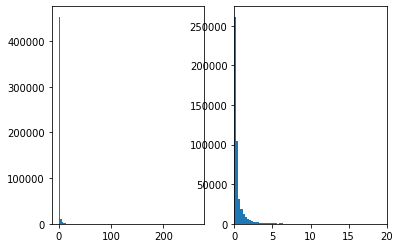

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

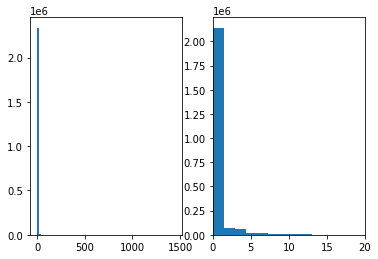

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [41]:
test_probs.describe()

count    471730.000000
mean          0.675879
std           2.791645
min           0.000000
25%           0.151961
50%           0.236099
75%           0.470851
max         264.820683
Name: probs_lg, dtype: float64

In [42]:
test_probs_lg = test_probs.copy()

## XGBOOST

In [29]:
from sklearn.metrics import mean_squared_error
from xgboost  import XGBRegressor
from sklearn.model_selection import ParameterGrid
params = ParameterGrid({"max_depth":[17], 'learning_rate':[0.2]})
for param in params:
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        # learner = XGBRegressor(n_estimators=1000,  random_state=42, **param)
        learner = XGBRegressor(n_estimators=1000,  random_state=42, n_jobs=-1, **param)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
    print(param)
    print('SCORE RMSE: ', score)

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:4.76579	validation_1-rmse:6.48638
[10]	validation_0-rmse:1.31391	validation_1-rmse:4.86417
[20]	validation_0-rmse:0.71564	validation_1-rmse:4.71558
[30]	validation_0-rmse:0.56027	validation_1-rmse:4.70830
[35]	validation_0-rmse:0.52775	validation_1-rmse:4.71127
********** 1 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.14105	validation_1-rmse:4.55726
[10]	validation_0-rmse:1.43836	validation_1-rmse:3.74445
[14]	validation_0-rmse:1.03845	validation_1-rmse:4.10134
********** 2 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:4.91711	validation_1-rmse:5.69215
[10]	validation_0-rmse:1.32016	validation_1-rmse:3.99116
[18]	validation_0-rmse:0.78850	validation_1-rmse:4.12489
********** 3 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.01578	validation_1-rmse:5.22911
[10]	validation_0-rmse:1.37075	validation_1-rmse:3.50607
[20]	validation_0-rmse:0.73391	validation_1-rmse:3.56945
********** 4 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.29592	validation_1-rmse:3.95337
[10]	validation_0-rmse:1.39208	validation_1-rmse:4.39986
[12]	validation_0-rmse:1.17091	validation_1-rmse:4.54105
{'learning_rate': 0.2, 'max_depth': 17}
SCORE RMSE:  3.8464632247138777


In [45]:
train_probs.name='probs_xg'
test_probs.name='probs_xg'
train_probs.to_pickle('../data/preprocessed/xgboost/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/xgboost/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/xgboost/fi.pkl')

#### Visualizacion de resultados

In [46]:
fi.sort_values(ascending=False)

MODELO_std_ENC                0.202490
MODELO_sum_ENC                0.138840
GAMA_mean_ENC                 0.088940
MODELO_mean_ENC               0.073637
ANNIO_SEMANA_FIN              0.071175
MODELO_max_ENC                0.068413
PORC_MODELO_mean_max_ENC      0.056006
MARCA_mean_ENC                0.048527
PTOVENTA_mean_ENC             0.043938
ANNIO_FIN                     0.033902
PTOVENTA_std_ENC              0.033617
MES_INICIO                    0.027189
MES_FIN                       0.024271
MARCA_sum_ENC                 0.014866
MARCA_std_ENC                 0.012110
PTOVENTA_sum_ENC              0.010091
PORC_MARCA_mean_max_ENC       0.009222
GAMA_sum_ENC                  0.008908
MARCA_max_ENC                 0.008325
GAMA_std_ENC                  0.008267
DIA_FIN                       0.006793
DIA_INICIO                    0.004433
PTOVENTA_max_ENC              0.003655
PORC_PTOVENTA_mean_max_ENC    0.002386
GAMA_max_ENC                  0.000000
ANNIO_INICIO             

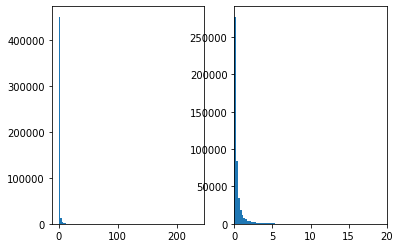

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

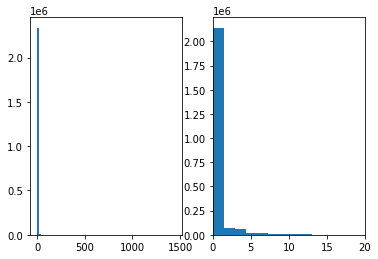

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [49]:
test_probs.describe()

count    471730.000000
mean          0.621364
std           2.319212
min           0.000000
25%           0.112507
50%           0.184381
75%           0.434693
max         234.555252
Name: probs_xg, dtype: float64

In [50]:
test_probs_xg = test_probs.copy()

## SUBMISION

In [52]:
# test_probs = test_probs_cb*0.55 + test_probs_lg*0.45
# test_probs = test_probs_cb.copy()
# test_probs = test_probs_lg.copy()
test_probs = test_probs_xg.copy()
test_probs.name = 'Demanda'
test_submit = test_probs.reset_index()[['ID','Demanda']]
test_submit

,ID,Demanda
0,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.308609
1,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.260210
2,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.285986
3,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.279807
4,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.276147
...,...,...
471725,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.100963
471726,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.104372
471727,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.104372
471728,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.104372


In [54]:
test_submit['Demanda'].describe()

count    471730.000000
mean          0.621364
std           2.319212
min           0.000000
25%           0.112507
50%           0.184381
75%           0.434693
max         234.555252
Name: Demanda, dtype: float64

In [55]:
test_submit.to_csv('../results/test_cv_xg.csv', index=False)

In [56]:
!kaggle competitions submit datathon-entel-2022-reto2 -f ../results/test_cv_xg.csv -m "test"

Successfully submitted to DATATHON ENTEL 2022 - Reto2



  0%|          | 0.00/101M [00:00<?, ?B/s]
  0%|          | 8.00k/101M [00:00<35:06, 50.5kB/s]
  0%|          | 208k/101M [00:00<03:03, 578kB/s]  
  1%|          | 888k/101M [00:00<00:44, 2.35MB/s]
  1%|1         | 1.23M/101M [00:00<00:38, 2.73MB/s]
  2%|1         | 1.65M/101M [00:00<00:32, 3.20MB/s]
  2%|1         | 2.02M/101M [00:01<01:09, 1.49MB/s]
  2%|2         | 2.47M/101M [00:01<00:52, 1.99MB/s]
  3%|2         | 2.94M/101M [00:01<00:41, 2.50MB/s]
  3%|3         | 3.41M/101M [00:01<00:34, 3.01MB/s]
  4%|3         | 3.86M/101M [00:01<00:30, 3.38MB/s]
  5%|4         | 4.80M/101M [00:01<00:21, 4.80MB/s]
  5%|5         | 5.34M/101M [00:02<00:55, 1.83MB/s]
  6%|5         | 5.81M/101M [00:02<00:47, 2.13MB/s]
  6%|6         | 6.21M/101M [00:02<00:44, 2.23MB/s]
  6%|6         | 6.56M/101M [00:03<00:43, 2.27MB/s]
  7%|6         | 6.88M/101M [00:03<00:43, 2.29MB/s]
  7%|7         | 7.17M/101M [00:03<00:42, 2.30MB/s]
  7%|7         | 7.45M/101M [00:03<00:42, 2.34MB/s]
  8%|7         | 7.71

## Entrenamiento con toda la data

In [30]:
punto_corte = 202249
Xt = train[train['ANNIO_SEMANA_FIN']<=punto_corte]
Xv = train[train['ANNIO_SEMANA_FIN']>punto_corte]
yt = y_train.loc[Xt.index]['TARGET']
yv = y_train.loc[Xv.index]['TARGET']
Xt.shape, yt.shape, Xv.shape, yv.shape

((2311477, 27), (2311477,), (47173, 27), (47173,))

In [31]:
%%time
from catboost import CatBoostRegressor
learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, max_depth=12, learning_rate=0.2)
learner.fit(Xt, yt,  early_stopping_rounds=10, 
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

0:	learn: 5.4036410	test: 5.4036410	test1: 3.0879021	best: 3.0879021 (0)	total: 738ms	remaining: 12m 16s
10:	learn: 3.2378676	test: 3.2378676	test1: 2.3421555	best: 2.3421555 (10)	total: 7.2s	remaining: 10m 47s
20:	learn: 2.7921433	test: 2.7921433	test1: 2.2685276	best: 2.2685276 (20)	total: 14.1s	remaining: 10m 58s
30:	learn: 2.5585794	test: 2.5585794	test1: 2.2424691	best: 2.2424691 (30)	total: 23.7s	remaining: 12m 19s
40:	learn: 2.4026517	test: 2.4026517	test1: 2.1697594	best: 2.1697594 (40)	total: 35.2s	remaining: 13m 43s
50:	learn: 2.2952972	test: 2.2952972	test1: 2.1195276	best: 2.1195276 (50)	total: 47.1s	remaining: 14m 36s
60:	learn: 2.1901801	test: 2.1901801	test1: 2.0896198	best: 2.0865902 (58)	total: 58.7s	remaining: 15m 3s
70:	learn: 2.1144962	test: 2.1144962	test1: 2.0885299	best: 2.0853500 (62)	total: 1m 10s	remaining: 15m 23s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 2.08535
bestIteration = 62

Shrink model to first 63 iterations.
CPU times: total

In [32]:
%%time
from lightgbm import LGBMRegressor
learner = LGBMRegressor(n_estimators=1000,  random_state=42, max_depth=15, learning_rate=0.2, num_leaves=100, min_split_gain=0.1,n_jobs=-1)
learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.22384	training's l2: 10.3931	valid_1's rmse: 2.44466	valid_1's l2: 5.97638
[20]	training's rmse: 2.68613	training's l2: 7.21532	valid_1's rmse: 2.26624	valid_1's l2: 5.13586
[30]	training's rmse: 2.47878	training's l2: 6.14435	valid_1's rmse: 2.18527	valid_1's l2: 4.77543
[40]	training's rmse: 2.35978	training's l2: 5.56857	valid_1's rmse: 2.10545	valid_1's l2: 4.43294
[50]	training's rmse: 2.23188	training's l2: 4.98127	valid_1's rmse: 2.04454	valid_1's l2: 4.18015
[60]	training's rmse: 2.13405	training's l2: 4.55417	valid_1's rmse: 2.04613	valid_1's l2: 4.18667
[70]	training's rmse: 2.06671	training's l2: 4.27128	valid_1's rmse: 1.98723	valid_1's l2: 3.94909
[80]	training's rmse: 2.00774	training's l2: 4.03103	valid_1's rmse: 1.97425	valid_1's l2: 3.89765
[90]	training's rmse: 1.94213	training's l2: 3.77188	valid_1's rmse: 1.96788	valid_1's l2: 3.87254
CPU times: total: 1min 12s
Wall time: 12.8 s


LGBMRegressor(learning_rate=0.2, max_depth=15, min_split_gain=0.1,
              n_estimators=1000, num_leaves=100, random_state=42)

In [33]:
%%time
from xgboost import XGBRegressor
learner = XGBRegressor(n_estimators=1000,  random_state=42,  max_depth=17, learning_rate=0.2, n_jobs=-1)
learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.06607	validation_1-rmse:2.88014
[10]	validation_0-rmse:1.35668	validation_1-rmse:1.67531
[20]	validation_0-rmse:0.74238	validation_1-rmse:1.78589
[21]	validation_0-rmse:0.71705	validation_1-rmse:1.79765
CPU times: total: 16min 36s
Wall time: 2min 29s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [47]:
%%time
learner_cb =  CatBoostRegressor(n_estimators=250, eval_metric = 'RMSE', random_state=42, max_depth=12, learning_rate=0.2)
learner_cb.fit(train, y_train, verbose = 10)

0:	learn: 5.3779690	total: 587ms	remaining: 2m 26s
10:	learn: 3.2745816	total: 6.63s	remaining: 2m 23s
20:	learn: 2.8137738	total: 13.5s	remaining: 2m 27s
30:	learn: 2.5769829	total: 20.5s	remaining: 2m 24s
40:	learn: 2.4306087	total: 28.8s	remaining: 2m 26s
50:	learn: 2.2800827	total: 37.4s	remaining: 2m 26s
60:	learn: 2.1837583	total: 45.9s	remaining: 2m 22s
70:	learn: 2.1175360	total: 54.2s	remaining: 2m 16s
80:	learn: 2.0527745	total: 1m 2s	remaining: 2m 11s
90:	learn: 1.9932291	total: 1m 11s	remaining: 2m 4s
100:	learn: 1.9518081	total: 1m 19s	remaining: 1m 57s
110:	learn: 1.9080822	total: 1m 28s	remaining: 1m 50s
120:	learn: 1.8724875	total: 1m 37s	remaining: 1m 43s
130:	learn: 1.8376590	total: 1m 46s	remaining: 1m 36s
140:	learn: 1.8021717	total: 1m 54s	remaining: 1m 28s
150:	learn: 1.7758613	total: 2m 3s	remaining: 1m 21s
160:	learn: 1.7488545	total: 2m 12s	remaining: 1m 13s
170:	learn: 1.7218857	total: 2m 21s	remaining: 1m 5s
180:	learn: 1.6960007	total: 2m 30s	remaining: 57.5

In [48]:
%%time
learner_lg = LGBMRegressor(n_estimators=1000,  random_state=42, max_depth=15, learning_rate=0.2, num_leaves=100, min_split_gain=0.1,n_jobs=-1)
learner_lg.fit(train, y_train, eval_metric="rmse",  verbose = 100)

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


CPU times: total: 7min 39s
Wall time: 1min 6s


LGBMRegressor(learning_rate=0.2, max_depth=15, min_split_gain=0.1,
              n_estimators=1000, num_leaves=100, random_state=42)

In [34]:
%%time
learner_xg = XGBRegressor(n_estimators=25, random_state=42,  max_depth=17, learning_rate=0.2, n_jobs=-1)
learner_xg.fit(train, y_train, eval_metric="rmse",  verbose = 10)

CPU times: total: 17min 20s
Wall time: 2min 33s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=25, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

### Visualizacion Resultados

In [49]:
features_importances = pd.Series(learner_cb.feature_importances_ / learner_cb.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 27
variables con importancia acumulada al 99% : 21
variables con zero importancia : 1


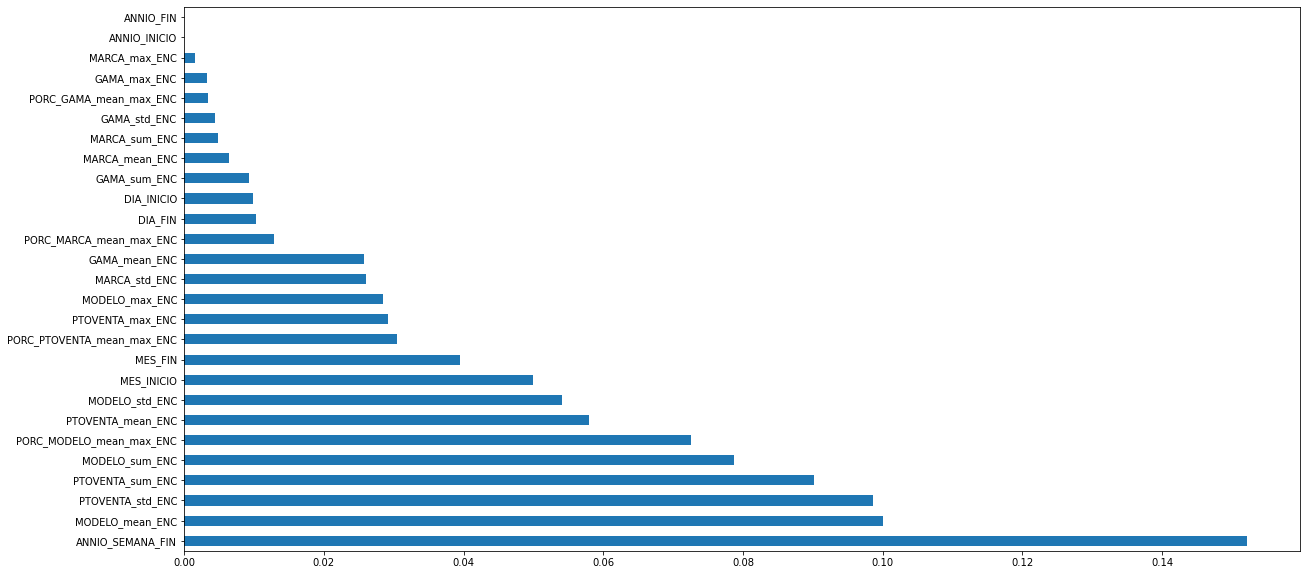

In [50]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

In [51]:
features_importances = pd.Series(learner_lg.feature_importances_ / learner_lg.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 27
variables con importancia acumulada al 99% : 19
variables con zero importancia : 2


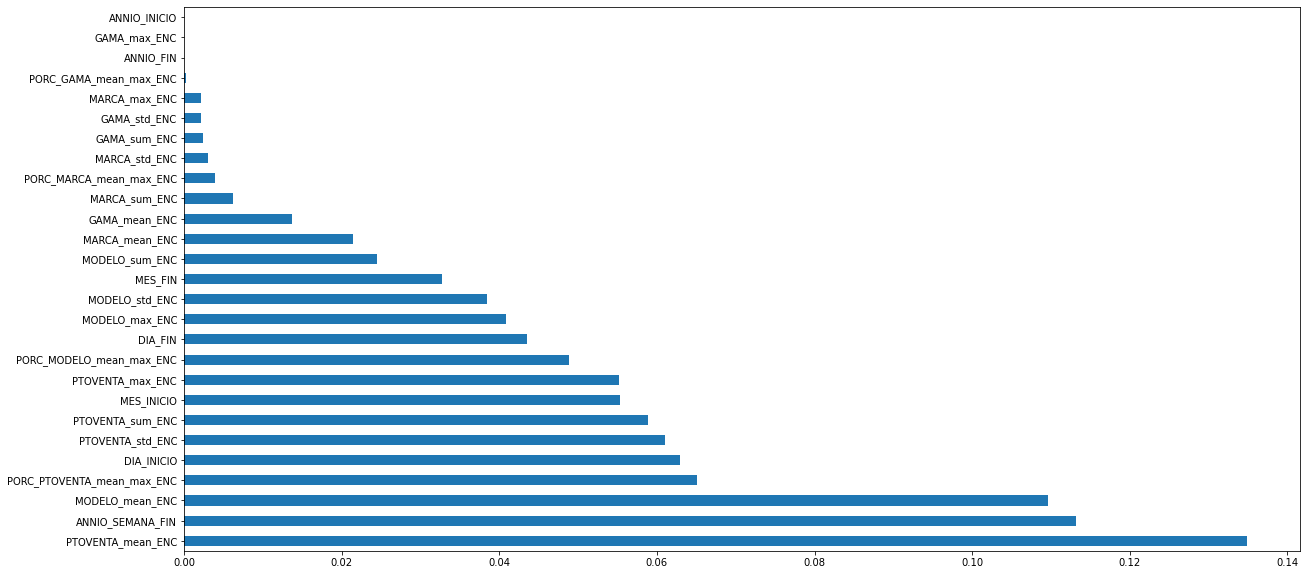

In [52]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

In [53]:
features_importances = pd.Series(learner_xg.feature_importances_ / learner_xg.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 27
variables con importancia acumulada al 99% : 20
variables con zero importancia : 3


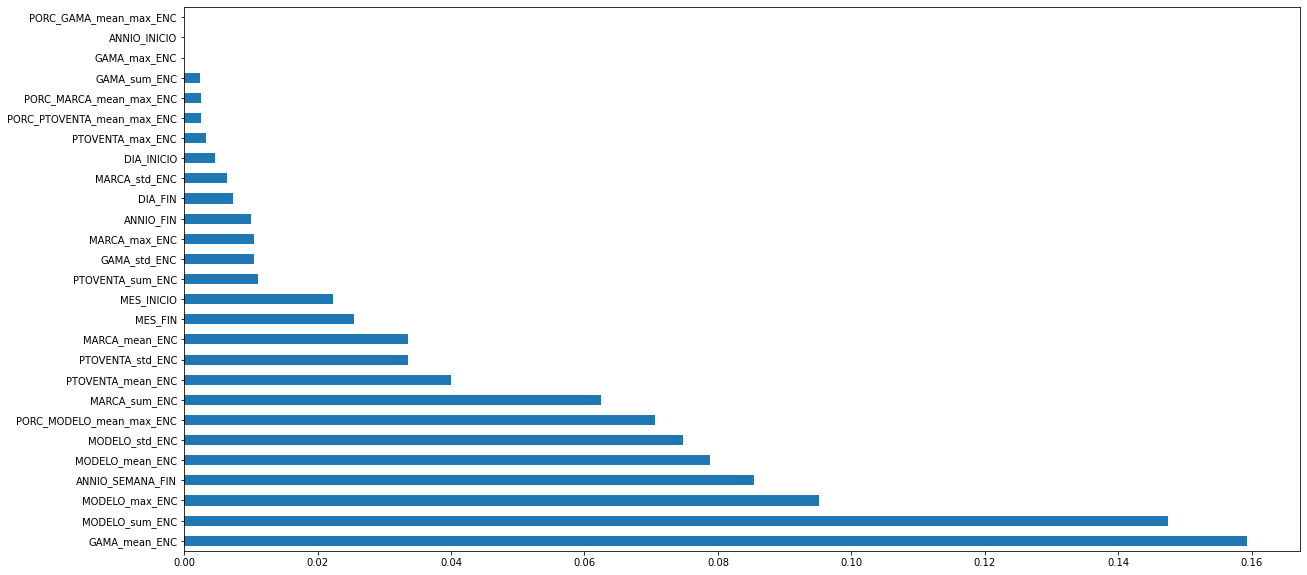

In [54]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

### SUBMISION 

In [102]:
if 'Demanda' in test.columns:
    test.drop(['Demanda'], axis=1, inplace=True)

In [103]:
test['Demanda'] = learner_lg.predict(test)*0.35 + learner_cb.predict(test)*0.30 +  learner_xg.predict(test)*0.35
# test['Demanda'] = learner_lg.predict(test)*0.5 + learner_xg.predict(test)*0.5
# test['Demanda'] = learner_lg.predict(test)
# test['Demanda'] = learner_cb.predict(test)
# test['Demanda'] = learner_xg.predict(test)
test['Demanda'] = test['Demanda'].apply(lambda x: 0 if x<0 else x)

In [104]:
test_submit = test.reset_index()[['ID','Demanda']]
test_submit

,ID,Demanda
0,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.268826
1,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.269073
2,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.273615
3,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.249232
4,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.248290
...,...,...
471725,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.021724
471726,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.023280
471727,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.023413
471728,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.000006


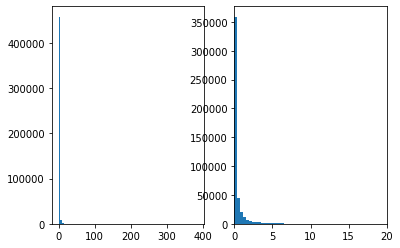

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test['Demanda'], bins=100);
ax2.hist(test['Demanda'], bins=1000);
plt.xlim(0,20);

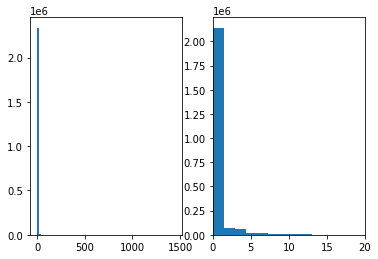

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [107]:
test_submit.to_csv('../results/ensamble_fulldata_xg_lg_cb.csv', index=False)
test_submit['Demanda'].describe()

count    471730.000000
mean          0.609709
std           3.056813
min           0.000000
25%           0.004293
50%           0.095237
75%           0.359492
max         384.199259
Name: Demanda, dtype: float64

In [108]:
test_submit_stacking= pd.read_csv('../results/test_stacking_xg_cb_lg.csv')
test_submit_stacking['Demanda'].describe()

count    471730.000000
mean          0.660625
std           2.409449
min           0.069554
25%           0.169745
50%           0.255588
75%           0.507586
max         229.333054
Name: Demanda, dtype: float64

In [109]:
test_submit['Demanda'] = test_submit_stacking['Demanda']*0.5 + test_submit['Demanda']*0.5
test_submit['Demanda'].describe()

count    471730.000000
mean          0.635167
std           2.693908
min           0.034777
25%           0.095574
50%           0.183855
75%           0.437843
max         306.766156
Name: Demanda, dtype: float64

In [110]:
test_submit.to_csv('../results/ensamble_fulldata_stacking_xg_lg_cb.csv', index=False)

In [111]:
!kaggle competitions submit datathon-entel-2022-reto2 -f ../results/ensamble_fulldata_stacking_xg_lg_cb.csv -m "test"

Successfully submitted to DATATHON ENTEL 2022 - Reto2



  0%|          | 0.00/101M [00:00<?, ?B/s]
  0%|          | 8.00k/101M [00:00<33:58, 52.2kB/s]
  0%|          | 208k/101M [00:00<03:04, 575kB/s]  
  1%|          | 872k/101M [00:00<00:46, 2.25MB/s]
  1%|1         | 1.15M/101M [00:00<00:42, 2.48MB/s]
  1%|1         | 1.52M/101M [00:00<00:36, 2.84MB/s]
  2%|1         | 1.88M/101M [00:00<00:34, 3.05MB/s]
  2%|2         | 2.32M/101M [00:00<00:29, 3.48MB/s]
  3%|2         | 2.71M/101M [00:01<00:29, 3.48MB/s]
  3%|3         | 3.06M/101M [00:01<00:29, 3.49MB/s]
  3%|3         | 3.41M/101M [00:01<00:31, 3.31MB/s]
  4%|3         | 3.84M/101M [00:01<00:28, 3.57MB/s]
  5%|4         | 4.70M/101M [00:01<00:20, 4.97MB/s]
  5%|5         | 5.20M/101M [00:01<00:20, 5.02MB/s]
  6%|5         | 5.70M/101M [00:01<00:20, 4.88MB/s]
  6%|6         | 6.17M/101M [00:02<00:31, 3.17MB/s]
  7%|6         | 6.64M/101M [00:02<00:30, 3.29MB/s]
  7%|6         | 7.02M/101M [00:02<00:59, 1.67MB/s]
  7%|7         | 7.40M/101M [00:02<00:51, 1.92MB/s]
  8%|7         | 7.69